# Bike Rental Data
Source: https://www.kaggle.com/lakshmi25npathi/bike-sharing-dataset

## Objective

Predict bike rental usage on a daily and hourly basis using environmental and seasonal data, with a second analysis done with Google Trends sata added in.

## Exploratory Data Analysis

### Import the Required Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
import seaborn as sns
import datetime as datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from treeinterpreter import treeinterpreter as ti
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50

### Read the Training Data

In [2]:
# Import the csv file
df = pd.read_csv('hour.csv', names=['Index','Date','Season','Year','Month','Hour','Holiday','Weekday','Workingday','Weather','Temp_Celsius','Temp_Celsius_Norm','Humidity','Windspeed','Users_Casual','Users_Registered','Count'], header=None, skiprows=1)
bike_share = pd.read_csv('Google_Trends_Bikeshare.csv', names=['Week', 'Popularity'], header=None, skiprows=1)

# Create Weeknum Columns and Convert Year to 0/1
df['Date'] = pd.to_datetime(df['Date'])
df['Weeknum'] = df['Date'].dt.week
bike_share['Week'] = pd.to_datetime(bike_share['Week'])
bike_share['Weeknum'] = bike_share['Week'].dt.week
bike_share['Year'] = bike_share['Week'].dt.year
bike_share['Year'] = bike_share['Year'].apply(lambda x: 0 if x == 2011 else 1)

# Merge in Google Trend Data to DataFrame
df = df.merge(bike_share[['Weeknum', 'Year', 'Popularity']], how='left', on=['Weeknum', 'Year']).drop(['Weeknum'], axis=1)
df = df.iloc[:,1:]
df = df[['Date','Season','Year','Month','Hour','Holiday','Weekday','Workingday','Weather','Temp_Celsius','Temp_Celsius_Norm','Humidity','Windspeed','Popularity','Users_Casual','Users_Registered','Count']]

### Data Sample

In [3]:
#Read the data
df.head()

,Date,Season,Year,Month,Hour,Holiday,Weekday,Workingday,Weather,Temp_Celsius,Temp_Celsius_Norm,Humidity,Windspeed,Popularity,Users_Casual,Users_Registered,Count
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,47,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,47,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,47,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,47,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,47,0,1,1


### Shape of the Dataset

In [4]:
print('This dataset has ' + str(df.shape[0]) + ' rows and ' + str(df.shape[1]) + ' columns' )

This dataset has 17569 rows and 17 columns


### Data Types by Column

In [5]:
df.dtypes

Date                 datetime64[ns]
Season                        int64
Year                          int64
Month                         int64
Hour                          int64
Holiday                       int64
Weekday                       int64
Workingday                    int64
Weather                       int64
Temp_Celsius                float64
Temp_Celsius_Norm           float64
Humidity                    float64
Windspeed                   float64
Popularity                    int64
Users_Casual                  int64
Users_Registered              int64
Count                         int64
dtype: object

### Summary Statistics

In [6]:
df.describe()

,Season,Year,Month,Hour,Holiday,Weekday,Workingday,Weather,Temp_Celsius,Temp_Celsius_Norm,Humidity,Windspeed,Popularity,Users_Casual,Users_Registered,Count
count,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000,17569.000000
mean,2.485400,0.507940,6.581820,11.547157,0.029768,2.999715,0.680744,1.429507,0.494523,0.473474,0.627901,0.190398,50.144061,35.445387,152.709488,188.154875
std,1.111818,0.499951,3.466866,6.914350,0.169952,2.007457,0.466201,0.641470,0.193051,0.172447,0.192690,0.122688,17.334493,49.138541,150.989145,180.976371
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,36.000000,4.000000,33.000000,39.000000
50%,2.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,50.000000,16.000000,114.000000,140.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,61.000000,48.000000,219.000000,279.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,100.000000,367.000000,886.000000,977.000000


### Check for Missing Values
No missing values present in the dataset.

In [7]:
df.isnull().sum()

Date                 0
Season               0
Year                 0
Month                0
Hour                 0
Holiday              0
Weekday              0
Workingday           0
Weather              0
Temp_Celsius         0
Temp_Celsius_Norm    0
Humidity             0
Windspeed            0
Popularity           0
Users_Casual         0
Users_Registered     0
Count                0
dtype: int64

## Outlier analysis
Outliers are defined as being above or below mean +/- 3.3 Standard Deviations

In [8]:
for column in ['Temp_Celsius', 'Temp_Celsius_Norm', 'Windspeed', 'Humidity', 'Popularity', 'Users_Casual', 'Users_Registered', 'Count']:
    mean = np.mean(df[[column]])
    std = np.std(df[[column]])
    Upper_Bound = mean + (std * 3.3)
    Lower_Bound = mean - (std * 3.3)
    try:
        Upper_Outlier_Count = len(df[df[column] < float(Lower_Bound)])
    except:
        Upper_Outlier_Count = 0
    try:
        Lower_Outlier_Count = len(df[df[column] > float(Upper_Bound)])
    except:
        Lower_Outlier_Count = 0
    print(column + ' has ' + str(Upper_Outlier_Count + Lower_Outlier_Count) + ' outliers')

Temp_Celsius has 0 outliers
Temp_Celsius_Norm has 0 outliers
Windspeed has 64 outliers
Humidity has 0 outliers
Popularity has 0 outliers
Users_Casual has 368 outliers
Users_Registered has 277 outliers
Count has 166 outliers


### Columns with Outliers are Normalized with Cube Root Transformation

In [9]:
df['Windspeed'] = df[['Windspeed']]**(1/3)
df['Users_Casual'] = df[['Users_Casual']]**(1/3)
df['Users_Registered'] = df[['Users_Registered']]**(1/3)
df['Count'] = df[['Count']]**(1/3)

### Dataset No Longer Has Outliers

In [10]:
for column in ['Temp_Celsius', 'Temp_Celsius_Norm', 'Windspeed', 'Humidity', 'Popularity', 'Users_Casual', 'Users_Registered', 'Count']:
    mean = np.mean(df[[column]])
    std = np.std(df[[column]])
    Upper_Bound = mean + (std * 3.3)
    Lower_Bound = mean - (std * 3.3)
    try:
        Upper_Outlier_Count = len(df[df[column] < float(Lower_Bound)])
    except:
        Upper_Outlier_Count = 0
    try:
        Lower_Outlier_Count = len(df[df[column] > float(Upper_Bound)])
    except:
        Lower_Outlier_Count = 0
    print(column + ' has ' + str(Upper_Outlier_Count + Lower_Outlier_Count) + ' outliers')

Temp_Celsius has 0 outliers
Temp_Celsius_Norm has 0 outliers
Windspeed has 0 outliers
Humidity has 0 outliers
Popularity has 0 outliers
Users_Casual has 0 outliers
Users_Registered has 0 outliers
Count has 0 outliers


### Correlation matrix
The Correlation Matrix tells about direct linear relationship (or overlap) between variables. 0 means there is no overlap, 1 means perfect overlap, and -1 means a perfect inverse relationship.

Because Users_Causal + Users_Registered = Count, the correlation with Count is very high, so they will be excluded in the analysis.

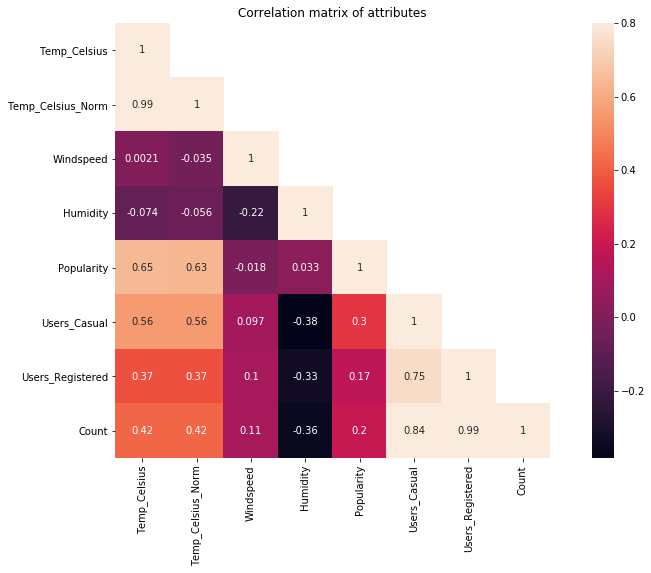

In [11]:
#Create the correlation matrix
corr_matrix=df[['Temp_Celsius', 'Temp_Celsius_Norm', 'Windspeed', 'Humidity', 'Popularity', 'Users_Casual', 'Users_Registered', 'Count']].corr()
mask=np.array(corr_matrix)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(corr_matrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

### Modelling the dataset
2/3 of the dataset is assigned as training data and the rest (1/3) becomes test data for validating the model.

In [12]:
#Split the dataset into the train and test data
X_train,X_test,y_train,y_test=train_test_split(df.iloc[:,0:-3],df.iloc[:,-1],test_size=0.33, random_state=3)

#Reset train index values
X_train.reset_index(inplace=True)
y_train=y_train.reset_index()
y_train= y_train['Count']

# Reset train index values
X_test.reset_index(inplace=True)
y_test=y_test.reset_index()
y_test= y_test['Count']

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(11771, 15) (5798, 15) (11771,) (5798,)


### Split the features into categorical and numerical features

In [13]:
#Create a new dataset for train attributes
train_attributes=X_train[['Season','Hour','Month','Year','Weekday','Holiday','Workingday','Weather','Humidity','Temp_Celsius','Windspeed','Popularity']]
#Create a new dataset for test attributes
test_attributes=X_test[['Season','Hour','Month','Year','Weekday','Holiday','Workingday','Weather','Humidity','Temp_Celsius','Windspeed','Popularity']]
#categorical attributes
cat_attributes=['Season','Holiday','Workingday','Weather','Year','Month','Weekday', 'Hour']
#numerical attributes
num_attributes=['Temp_Celsius','Windspeed','Humidity','Popularity']

### One-Hot Encode Categorical Attributes
Categorical variables are converted into new columns that are binary as 0 or 1.

In [14]:
#To get dummy variables to encode the categorical features to numeric
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)

## Training dataset

### Rename the Columns for Easier Interpretation

In [15]:
#Rename the columns
cols= {
    'Season_1':'Spring',
    'Season_2':'Summer',
    'Season_3':'Fall',
    'Season_4':'Winter',
    'Holiday_0':'Holiday_True',
    'Holiday_1':'Holiday_False',
    'Holiday_1':'Holiday_True',
    'Workingday_0':'Workingday_False',
    'Workingday_1':'Workingday_True',
    'Weather_1':'Few_Clouds',
    'Weather_2':'Mist',
    'Weather_3':'Light_Rain_Snow',
    'Weather_4':'Heavy_Rain_Snow',
    'Year_0':'Year_2011',
    'Year_1':'Year_2012',
    'Month_1':'January',
    'Month_2':'February',
    'Month_3':'March',
    'Month_4':'April',
    'Month_5':'May',
    'Month_6':'June',
    'Month_7':'July',
    'Month_8':'August',
    'Month_9':'September',
    'Month_10':'October',
    'Month_11':'November',
    'Month_12':'December',
    'Weekday_0':'Sunday',
    'Weekday_1':'Monday',
    'Weekday_2':'Tuesday',
    'Weekday_3':'Wednesday',
    'Weekday_4':'Thursday',
    'Weekday_5':'Friday',
    'Weekday_6':'Saturday',
    'Hour_0':'0000',
    'Hour_1':'0100',
    'Hour_2':'0200',
    'Hour_3':'0300',
    'Hour_4':'0400',
    'Hour_5':'0500',
    'Hour_6':'0600',
    'Hour_7':'0700',
    'Hour_8':'0800',
    'Hour_9':'0900',
    'Hour_10':'1000',
    'Hour_11':'1100',
    'Hour_12':'1200',
    'Hour_13':'1300',
    'Hour_14':'1400',
    'Hour_15':'1500',
    'Hour_16':'1600',
    'Hour_17':'1700',
    'Hour_18':'1800',
    'Hour_19':'1900',
    'Hour_20':'2000',
    'Hour_21':'2100',
    'Hour_22':'2200',
    'Hour_23':'2300'
}


train_encoded_attributes.rename(columns=cols, inplace=True)

test_encoded_attributes.rename(columns=cols, inplace=True)

In [16]:
#Training dataset for modelling
X_train=train_encoded_attributes

## Linear Regression Model

In [17]:
#training model
lr_model=linear_model.LinearRegression()

### Fit the Model to Training Data

In [18]:
#fit the trained model
lr_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Linear Regression Model Accuracy
The model is approximately 81% Accurate

In [19]:
#Accuracy of the model
lr=lr_model.score(X_train,y_train)
print('Accuracy of the model :',lr)

Accuracy of the model : 0.8103451260082234


## Linear Regression Evalution Metrics

### Linear Regression R-squared

The R-squared is 0.81 on average for a 3-Fold Cross Validation. This means that the model is only able to predict 81% of the variance for the target variable.

In [20]:
r2_scores = cross_val_score(lr_model, X_train, y_train, cv=10)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.8080060298039526


## Model Performance on Test Data

In [21]:
#Test dataset for prediction
X_test=test_encoded_attributes

### Predict the Test Data

In [22]:
#predict the model
lr_pred=lr_model.predict(X_test)

### Root Mean Square Error and Mean Absolute Error Scores
This means that on average, the predicted value is about 0.7 away from the true value

In [23]:
#Root mean square error 
rmse=math.sqrt(metrics.mean_squared_error(y_test,lr_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,lr_pred)
print('Root Mean Square Error :',rmse)
print('Mean Absolute Error :',mae)

Root Mean Square Error : 0.888715764266583
Mean Absolute Error : 0.6952937689301303


## Decision Tree Regressor

In [24]:
#training the model
dtr=DecisionTreeRegressor(min_samples_split=2,max_leaf_nodes=50)

### Fit the Model to Training Data

In [25]:
#Fit the trained model
dtr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=50, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Decision Tree Regression Accuracy
The Decision Tree is approximately 77% Accurate, making it underperform the Linear Regression

In [26]:
#Accuracy score of the model
dtr_score=dtr.score(X_train,y_train)
print('Accuracy of Model :',dtr_score)

Accuracy of Model : 0.7690975445229152


## Model Evalution Metrics

### Decision Tree Regressor R-squared

The R-squared or coefficient of determination is 0.76 on average for 10-fold cross validation, predicting about 75% of the variance, again underperforming the linear regression model.

In [27]:
#R-squared scores
r2_scores = cross_val_score(dtr, X_train, y_train, cv=10)
print('R-Squared Scores :',np.average(r2_scores))

R-Squared Scores : 0.7604612717333206


## Model Performance on Test Data

In [28]:
#predict the model
dtr_pred=dtr.predict(X_test)

### Root Mean Square Error and Mean Absolute Error Scores

In [29]:
#Root mean square error
rmse=math.sqrt(metrics.mean_squared_error(y_test,dtr_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,dtr_pred)
print('Root Mean Square Error :',rmse)
print('Mean Absolute Error :',mae)

Root Mean Square Error : 0.9805139178792214
Mean Absolute Error : 0.7603413782851554


## Random Forest

In [30]:
#Training the model
X_train=train_encoded_attributes
rf=RandomForestRegressor(n_estimators=200)

### Fit the Model to Training Data

In [31]:
#Fit the trained model
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Random Forest Accuracy
The Random Forest Regressor has a incredibly high 99.3% Accuracy score, which brings up the concern that it might be overfit.

In [32]:
#accuracy of the model
rf_score =rf.score(X_train,y_train)
print('Accuracy of the Model :',rf_score)

Accuracy of the Model : 0.9926633045790223


### Random Forest Regressor R-Squared
The very high 0.94 R-Squared alleviates the concern of overfitting, because it was averaged over 10 different folds of data and still able to predict all but 6% of the variance in the data.

In [33]:
#R-squared scores
r2_scores = cross_val_score(rf, X_train, y_train, cv=10)
print('R-Squared Scores :',np.average(r2_scores))

R-Squared Scores : 0.9448968160755719


## Model Performance on Test Data

In [34]:
#predict the model
X_test=test_encoded_attributes
rf_pred=rf.predict(X_test)

### Root Mean Square Error and Mean Absolute Error Scores
Finally, the improved error scores show that this model is in fact performing very well. The error is less than half of the Linear Regression, the second best performer in this analysis.

In [35]:
#Root mean square error
rmse = math.sqrt(metrics.mean_squared_error(y_test,rf_pred))
print('Root Mean Square Error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,rf_pred)
print('Mean Absolute Error :',mae)

Root Mean Square Error : 0.46465092060230395
Mean Absolute Error : 0.32752847073014685


### Export Prediction Results for Analysis

In [36]:
df1=pd.DataFrame(y_test)
df2=pd.DataFrame(rf_pred, columns=['Predicted_Usage'])
Bike_predictions=pd.merge(df1,df2,left_index=True,right_index=True)
Bike_predictions.to_excel('Bike_Renting_Python.xlsx')

## Infer Random Forest Coefficients
As the Random Forest Regressor was our most powerful model, we want to extract the most valuable coefficients. Random Forests do not natively give this information, so it must be infered from the results.

In [37]:
prediction, bias, contributions = ti.predict(rf, X_test)
#Prediction is the sum of bias and feature contributions

In [38]:
rf_coef = np.average(contributions, axis=0)
rf_Coefficients = pd.DataFrame(rf_coef, index=X_train.columns, columns=['Coefficient'])

## 10 Largest Coefficients
This tells us that these 10 coefficients have the strongest effect on the overall number of Count. Unsurprisingly, the Temperature in Celsisus, and then Humidity play the strongest roles, as the weather is a major factor of when people wish to ride a bike.

In [39]:
rf_Coefficients.sort_values(['Coefficient'], axis=0, ascending=False).iloc[:10]

,Coefficient
Temp_Celsius,0.018265
Humidity,0.013012
0400,0.012847
0500,0.008007
Light_Rain_Snow,0.005777
2200,0.005500
Spring,0.003045
Year_2012,0.002898
Year_2011,0.002359
2300,0.001455
